# Compare kriging and cokriging prediction results

NOTE:
- ratio cokriging s.e. / kriging s.e. is nearly unity everywhere

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from cmcrameri import cm

import fields
import model
import prediction
import plot
from data_utils import get_main_coords

%matplotlib inline

In [3]:
with xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc") as ds:
    ds = ds.where(ds.time.dt.year > 2014, drop=True)
da_evi = xr.open_dataarray("../data/exp_pro/MODIS_05deg_monthly_conus_new.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

month_xco2 = "2016-08-01"
month_sif = "2016-07-01"

## Collect SIF data for comparison
---

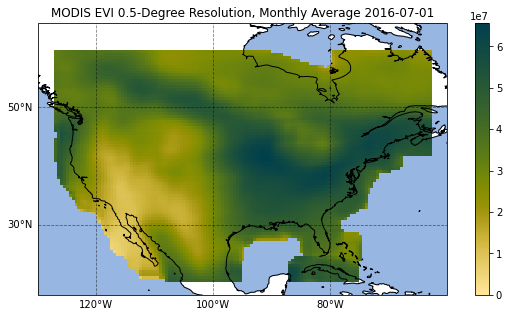

In [4]:
plot.plot_da(da_evi.sel(time=month_sif), vmin=0, title=f"MODIS EVI 0.5-Degree Resolution, Monthly Average {month_sif}")

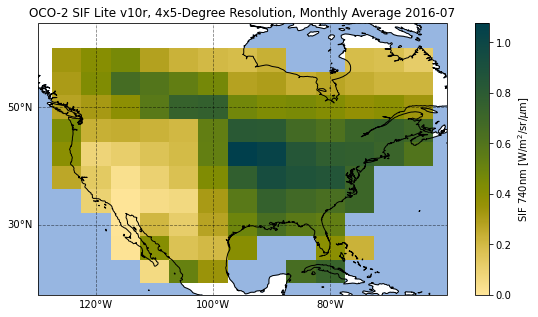

In [5]:
ds_show = get_main_coords(ds_sif).sel(time=month_sif)
title = f"OCO-2 SIF Lite v10r, 4x5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_show.time, unit='M')}"
units="SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_show.sif, vmin=0, title=title, label=units)

In [6]:
df_data_xco2 = (
    get_main_coords(ds_xco2)["xco2"]
    .sel(time=month_xco2)
    .to_dataframe()
    .reset_index()
    .drop(columns="time")
    .dropna(subset=["xco2"])
)
df_data_sif = (
    get_main_coords(ds_sif)["sif"]
    .sel(time=month_sif)
    .to_dataframe()
    .reset_index()
    .drop(columns="time")
    .dropna(subset=["sif"])
)
df_data_sif


,lon,lat,sif
4,-125.0,38.0,0.261279
5,-125.0,42.0,0.392038
6,-125.0,46.0,0.439987
7,-125.0,50.0,0.275884
8,-125.0,54.0,0.303046
...,...,...,...
125,-65.0,42.0,0.599065
126,-65.0,46.0,0.686031
127,-65.0,50.0,0.335955
128,-65.0,54.0,0.214709


## Produce and check kriging results
---

In [7]:
# Setup
datasets = [ds_sif]
covariates = [["evi"]]
timedeltas = [0]
vario_config = fields.VarioConfig(1500, 30, n_procs=1)

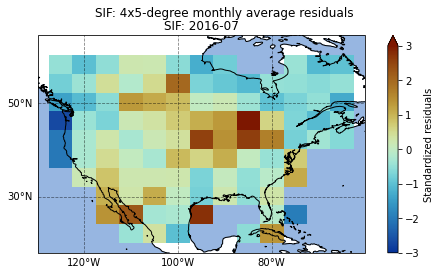

In [9]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64(month_sif), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)
plot.plot_fields(mf, ["SIF"])

In [11]:
df_sif_res = mf.fields[0].to_dataframe(main=True)[["lon", "lat", "sif"]]
df_sif_res

,lon,lat,sif
4,-125.0,38.0,-2.031800
5,-125.0,42.0,-2.025086
6,-125.0,46.0,-2.679888
7,-125.0,50.0,-1.426386
8,-125.0,54.0,-0.789442
...,...,...,...
125,-65.0,42.0,-0.617893
126,-65.0,46.0,-0.562582
127,-65.0,50.0,-1.292853
128,-65.0,54.0,-0.476114


In [12]:
mod = model.MultivariateMatern(n_procs=1)
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.113981,"(0.4, 3.5)"
1,nu_11,0.855851,"(0.2, 3.5)"
2,len_scale_11,672.448792,"(100.0, 2000.0)"
3,nugget_11,0.025305,"(0.0, 0.2)"


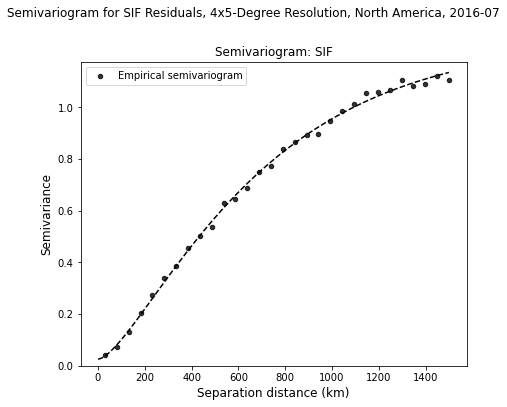

In [13]:
title = "Semivariogram for SIF Residuals, 4x5-Degree Resolution, North America, 2016-07"
plot.plot_variograms(mod.fit_result, ["SIF"], title=title)

In [15]:
pcoords = prediction.prediction_coords()
P = prediction.Predictor(mod, mf, covariates=da_evi)
ds_krig = P(0, pcoords, max_dist=1e3)
# ds_krig = P(0, pcoords, max_dist=1e3, postprocess=False)

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:205: RuntimeWarning: invalid value encountered in sqrt
  pred_std = np.sqrt(c0 - np.matmul(cov_weights, local_pred_cov))


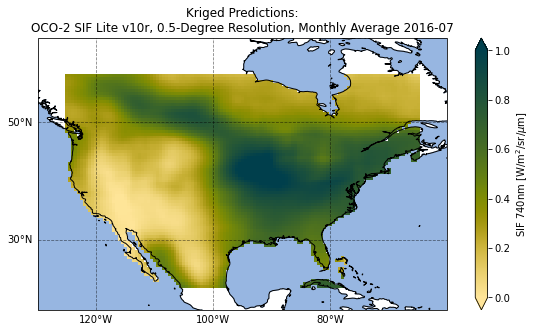

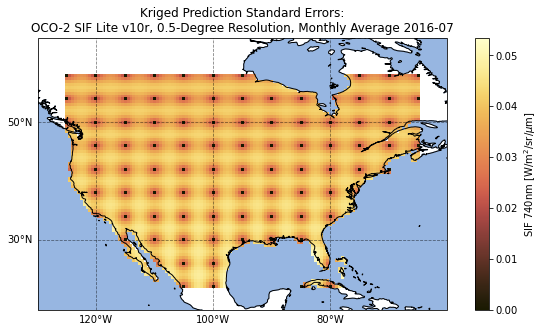

In [16]:
title_pred = f"Kriged Predictions:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_krig.time, unit='M')}"
title_err = f"Kriged Prediction Standard Errors:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_krig.time, unit='M')}"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_krig.pred, vmin=0, vmax=1, title=title_pred, label=units)
plot.plot_da(ds_krig.pred_err, cmap=cm.lajolla_r, title=title_err, label=units)
# residuals
# plot.plot_da(ds_krig.pred, cmap=cm.roma_r)
# plot.plot_da(ds_krig.pred_err, cmap=cm.lajolla_r, vmin=0)

In [17]:
df_krig = (
    ds_krig.to_dataframe()
    .reset_index()
    .drop(columns=["time", "covariates"])
    .dropna(subset=["pred"])
    .merge(df_data_sif, on=["lon", "lat"], how="right")
)
# df_krig = (
#     ds_krig.to_dataframe()
#     .reset_index()
#     .drop(columns=["time"])
#     .dropna(subset=["pred"])
#     .merge(df_sif_res, on=["lon", "lat"], how="right")
# )
df_krig["diff"] = df_krig["sif"] - df_krig["pred"]
df_krig


,lon,lat,pred,pred_err,sif,diff
0,-125.0,38.0,NaN,NaN,0.261279,NaN
1,-125.0,42.0,NaN,NaN,0.392038,NaN
2,-125.0,46.0,NaN,NaN,0.439987,NaN
3,-125.0,50.0,0.275884,0.0,0.275884,3.280339e-09
4,-125.0,54.0,0.303046,0.0,0.303046,1.677475e-09
...,...,...,...,...,...,...
99,-65.0,42.0,NaN,NaN,0.599065,NaN
100,-65.0,46.0,0.686031,0.0,0.686031,-3.284264e-09
101,-65.0,50.0,NaN,NaN,0.335955,NaN
102,-65.0,54.0,0.214709,0.0,0.214709,-9.076655e-10


In [18]:
df_krig[["diff", "pred_err"]].describe()

,diff,pred_err
count,8.700000e+01,8.700000e+01
mean,8.971517e-10,3.596923e-10
std,3.421745e-09,5.888198e-10
min,-1.602786e-08,0.000000e+00
25%,-3.234956e-10,0.000000e+00
50%,3.594703e-10,0.000000e+00
75%,2.430726e-09,1.281763e-09
max,1.089962e-08,1.812686e-09


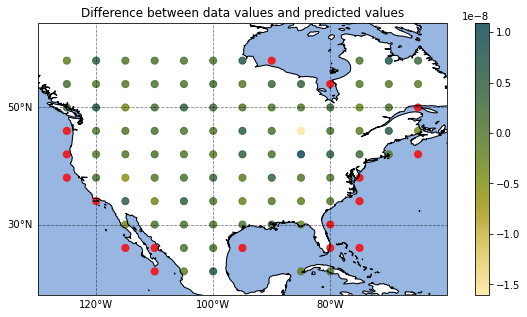

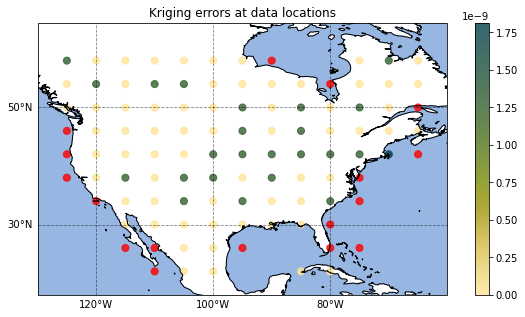

In [19]:
plot.plot_df(df_krig, "diff", s=50, title="Difference between data values and predicted values")
plot.plot_df(df_krig, "pred_err", s=50, title="Kriging errors at data locations")

## Produce and check cokriging results
---

In [20]:
# Setup
datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = [0, -1]
vario_config = fields.VarioConfig(1500, 30, n_procs=2)

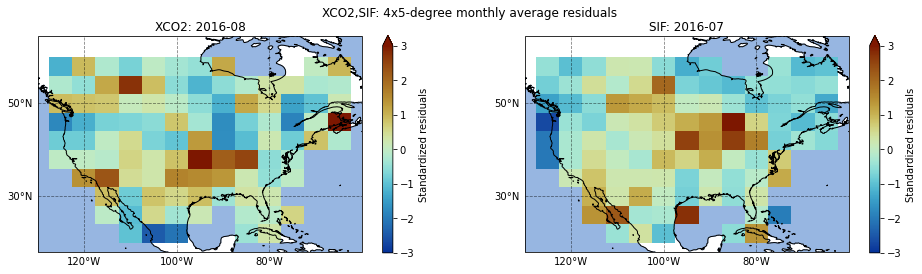

In [21]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64(month_xco2), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)
plot.plot_fields(mf, ["XCO2", "SIF"])

In [26]:
df_sif_res = mf.fields[1].to_dataframe(main=True)[["lon", "lat", "sif"]]
df_sif_res

,lon,lat,sif
4,-125.0,38.0,-2.031800
5,-125.0,42.0,-2.025086
6,-125.0,46.0,-2.679888
7,-125.0,50.0,-1.426386
8,-125.0,54.0,-0.789442
...,...,...,...
125,-65.0,42.0,-0.617893
126,-65.0,46.0,-0.562582
127,-65.0,50.0,-1.292853
128,-65.0,54.0,-0.476114


In [27]:
mod = model.MultivariateMatern(n_procs=2)
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.022804,"(0.4, 3.5)"
1,sigma_22,1.111082,"(0.4, 3.5)"
2,nu_11,0.761062,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,0.865863,"(0.2, 3.5)"
5,len_scale_11,366.394072,"(100.0, 2000.0)"
6,len_scale_12,2000.000000,"(100.0, 2000.0)"
7,len_scale_22,665.881210,"(100.0, 2000.0)"
8,nugget_11,0.057784,"(0.0, 0.2)"
9,nugget_22,0.025702,"(0.0, 0.2)"


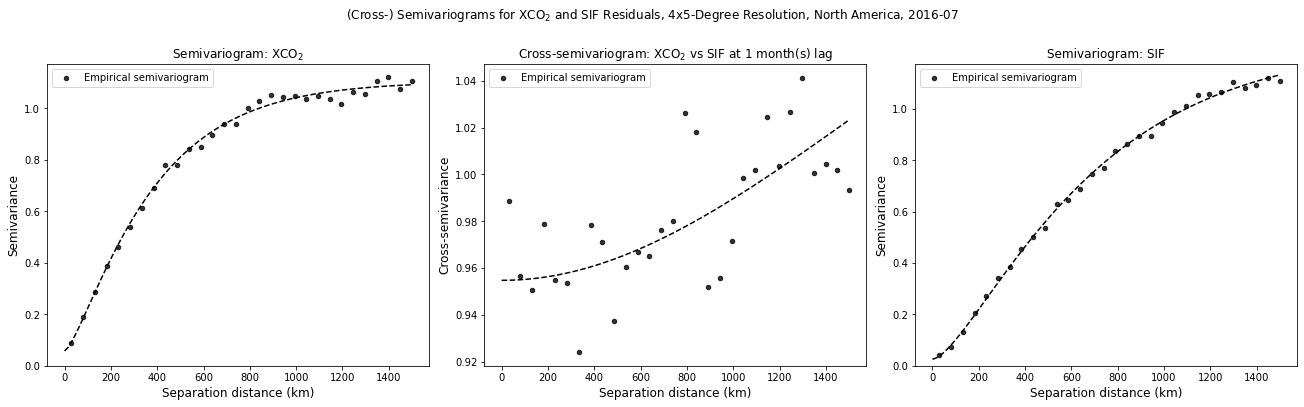

In [28]:
title = "(Cross-) Semivariograms for XCO$_2$ and SIF Residuals, 4x5-Degree Resolution, North America, 2016-07"
plot.plot_variograms(mod.fit_result, ["XCO$_2$", "SIF"], title=title)

In [29]:
pcoords = prediction.prediction_coords()
P = prediction.Predictor(mod, mf, covariates=da_evi)
ds_cokrig = P(1, pcoords, max_dist=1e3)
# ds_cokrig = P(1, pcoords, max_dist=1e3, postprocess=False)
# P = prediction.Predictor(mod, mf)
# ds_cokrig = P(0, pcoords, max_dist=1e3)

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:205: RuntimeWarning: invalid value encountered in sqrt
  pred_std = np.sqrt(c0 - np.matmul(cov_weights, local_pred_cov))


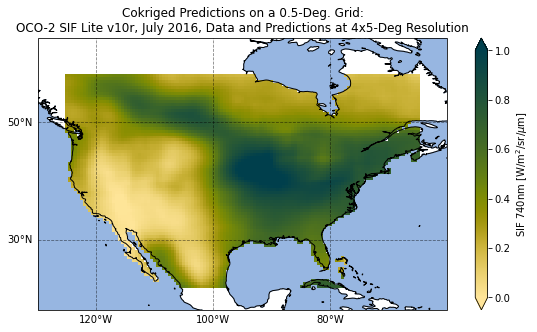

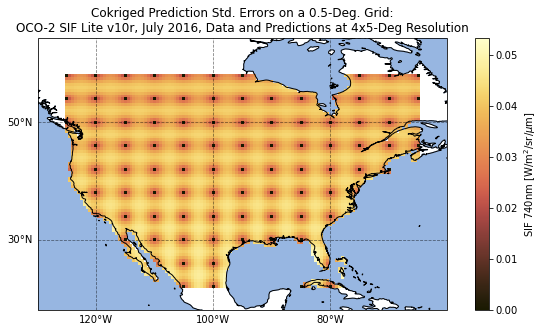

In [30]:
# title_pred = f"Cokriged Predictions:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_cokrig.time, unit='M')}"
# title_err = f"Cokriged Prediction Standard Errors:\nOCO-2 SIF Lite v10r, 0.5-Degree Resolution, Monthly Average {np.datetime_as_string(ds_cokrig.time, unit='M')}"
title_pred = f"Cokriged Predictions on a 0.5-Deg. Grid:\nOCO-2 SIF Lite v10r, July 2016, Data and Predictions at 4x5-Deg Resolution"
title_err = f"Cokriged Prediction Std. Errors on a 0.5-Deg. Grid:\nOCO-2 SIF Lite v10r, July 2016, Data and Predictions at 4x5-Deg Resolution"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_cokrig.pred, vmin=0, vmax=1, title=title_pred, label=units, filename="SIF_predictions")
plot.plot_da(ds_cokrig.pred_err, cmap=cm.lajolla_r, title=title_err, label=units, filename="SIF_uncertainty")
# residuals
# plot.plot_da(ds_cokrig.pred, cmap=cm.roma_r)
# plot.plot_da(ds_cokrig.pred_err, cmap=cm.lajolla_r, vmin=0)

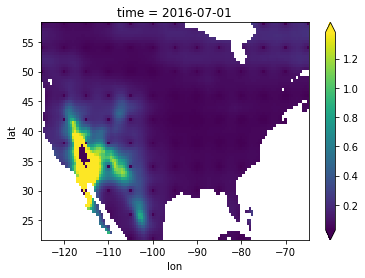

In [31]:
(ds_cokrig.pred_err / ds_cokrig.pred).T.plot(robust=True)

In [32]:
df_cokrig = (
    ds_cokrig.to_dataframe()
    .reset_index()
    # .drop(columns=["time", "covariates"])
    .drop(columns=["time"])
    .dropna(subset=["pred"])
    .merge(df_data_sif, on=["lon", "lat"], how="right")
)
# df_cokrig = (
#     ds_cokrig.to_dataframe()
#     .reset_index()
#     .drop(columns=["time"])
#     .dropna(subset=["pred"])
#     .merge(df_sif_res, on=["lon", "lat"], how="right")
# )
df_cokrig["diff"] = df_cokrig["sif"] - df_cokrig["pred"]
df_cokrig


,lon,lat,pred,pred_err,covariates,sif,diff
0,-125.0,38.0,NaN,NaN,NaN,0.261279,NaN
1,-125.0,42.0,NaN,NaN,NaN,0.392038,NaN
2,-125.0,46.0,NaN,NaN,NaN,0.439987,NaN
3,-125.0,50.0,0.275884,0.000000e+00,35111796.0,0.275884,3.280339e-09
4,-125.0,54.0,0.303046,0.000000e+00,33627532.0,0.303046,1.677475e-09
...,...,...,...,...,...,...,...
99,-65.0,42.0,NaN,NaN,NaN,0.599065,NaN
100,-65.0,46.0,0.686031,0.000000e+00,53155548.0,0.686031,-3.284264e-09
101,-65.0,50.0,NaN,NaN,NaN,0.335955,NaN
102,-65.0,54.0,0.214709,1.281763e-09,27433438.0,0.214709,-9.076655e-10


In [33]:
df_cokrig[["diff", "pred_err"]].describe()

,diff,pred_err
count,8.700000e+01,8.700000e+01
mean,8.971517e-10,4.013632e-10
std,3.421745e-09,6.253326e-10
min,-1.602786e-08,0.000000e+00
25%,-3.234956e-10,0.000000e+00
50%,3.594702e-10,0.000000e+00
75%,2.430726e-09,1.281763e-09
max,1.089962e-08,1.812686e-09


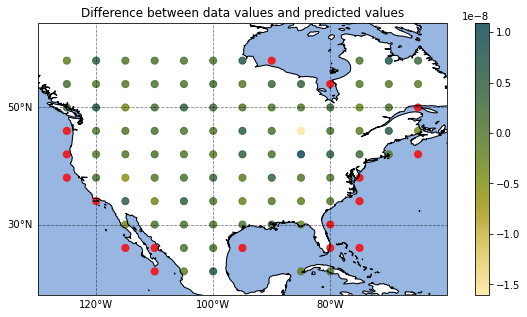

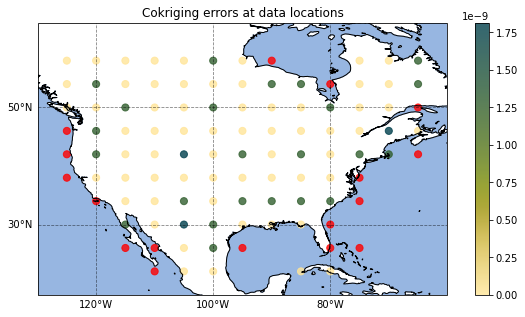

In [34]:
plot.plot_df(df_cokrig, "diff", s=50, title="Difference between data values and predicted values")
plot.plot_df(df_cokrig, "pred_err", s=50, title="Cokriging errors at data locations")

## Produce error ratio comparison map

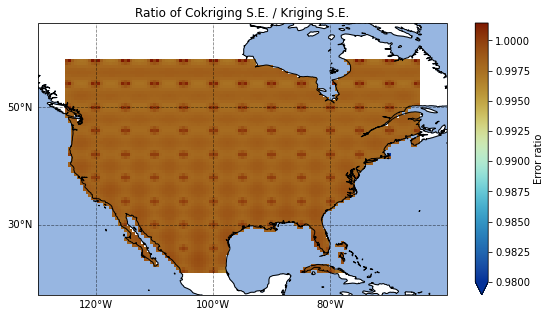

In [35]:
df_cokrig_err = (
    ds_cokrig["pred_err"].to_dataframe().reset_index().drop(columns="time").dropna()
)
df_krig_err = (
    ds_krig["pred_err"].to_dataframe().reset_index().drop(columns="time").dropna()
)
df_err_ratio = pd.merge(
    df_cokrig_err,
    df_krig_err,
    on=["lon", "lat"],
    how="outer",
    suffixes=["_cokrig", "_krig"],
)
df_err_ratio["ratio"] = df_err_ratio["pred_err_cokrig"] / df_err_ratio["pred_err_krig"]
df_err_ratio["ratio"][df_err_ratio["ratio"] == 0.0] = np.nan
with pd.option_context("mode.use_inf_as_null", True):
    df_err_ratio.fillna(1, inplace=True)

da_err_ratio = df_err_ratio.set_index(["lon", "lat"]).to_xarray()["ratio"]

title = "Ratio of Cokriging S.E. / Kriging S.E."
plot.plot_da(da_err_ratio, cmap=cm.roma_r, title=title, label="Error ratio", vmin=0.98)